SIN-392 - Introdução ao Processamento Digital de Imagens (2023-1)

# Aula 14 - Filtragem no domínio da frequência

Prof. João Fernando Mari ([*joaofmari.github.io*](https://joaofmari.github.io/))

---

## Importando as bibliotecas
---

In [7]:
import numpy as np
from scipy import ndimage
from skimage import transform, color

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

### %matplotlib inline

## Exemplo com uma imagem simples
---

* Vamos começar usando uma imagem simples com um retângulo branco sobre um fundo escuro.

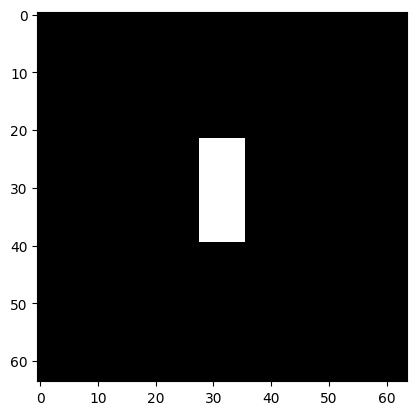

In [8]:
img_ret = np.zeros([64, 64], dtype=float)
img_ret[22:22+18, 28:28+8] = 1.

# Plota a imagem
plt.figure()
plt.imshow(img_ret, cmap='gray')
plt.show()

### Transformando a imagem

* Iremos gerar duas versões transformadas da imagem original, uma transladada e outra rotacionada.

In [9]:
# Translation
# -----------
tform = transform.EuclideanTransform(
            translation=(16, -16)
        )

img_ret_t = transform.warp(img_ret, tform.inverse)

# Rotation
# --------
shift_y, shift_x = np.array(img_ret.shape) // 2

tf_r = transform.SimilarityTransform(rotation=np.deg2rad(60))
tf_t1 = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
tf_t2 = transform.SimilarityTransform(translation=[shift_x, shift_y])

img_ret_r = transform.warp(img_ret, (tf_t1 + (tf_r + tf_t2)).inverse, order=3)

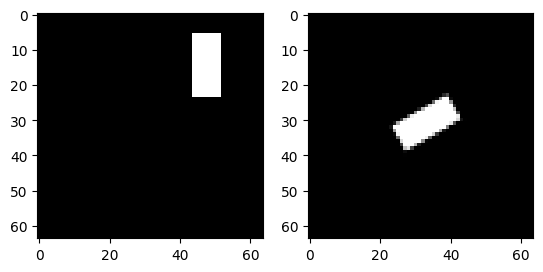

In [10]:
# Plota a imagem
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_ret_t, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_ret_r, cmap='gray')
plt.show()

### Aplicando a Transformada de Fourier adiante e a Transformada de Fourier inversa

In [11]:
img_list = [img_ret, img_ret_t, img_ret_r]

img_fft_list = []
img_fft_s_list = []
img_ifft_s_list = []
img_ifft_list = []

for img in img_list:
    img_fft = np.fft.fft2(img)
    img_fft_s = np.fft.fftshift(img_fft)
    img_ifft_s = np.fft.ifftshift(img_fft_s)
    img_ifft = np.fft.ifft2(img_ifft_s)
    
    img_fft_list.append(img_fft)
    img_fft_s_list.append(img_fft_s)
    img_ifft_s_list.append(img_ifft_s)
    img_ifft_list.append(img_ifft)

#### Plotando as imagens

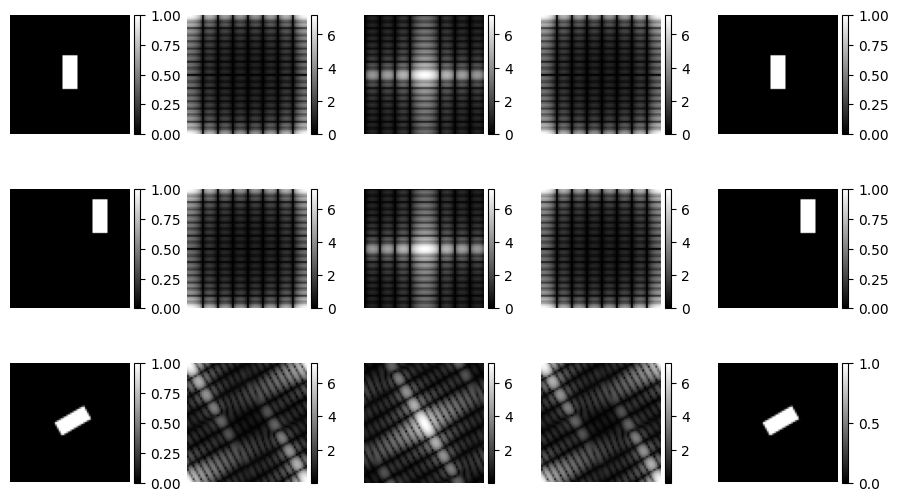

In [12]:
fig, ax  = plt.subplots(3, 5, figsize=(9,6))
for i, (img, img_fft, img_fft_s, img_ifft_s, img_ifft) in enumerate(zip(img_list, img_fft_list, img_fft_s_list, img_ifft_s_list, img_ifft_list)):

    img_1 = ax[i, 0].imshow(img, cmap='gray')
    ax[i,0].axis('off')
    # Barra de cores
    divider = make_axes_locatable(ax[i,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_1, cax=cax)
    
    img_2 = ax[i,1].imshow(np.log2(1 + np.abs(img_fft)), cmap='gray')
    ax[i,1].axis('off')
    # Barra de cores
    divider = make_axes_locatable(ax[i,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_2, cax=cax)
    
    img_3 = ax[i,2].imshow(np.log2(1 + np.abs(img_fft_s)), cmap='gray')
    ax[i,2].axis('off')
    # Barra de cores
    divider = make_axes_locatable(ax[i,2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_3, cax=cax)
    
    img_4 = ax[i,3].imshow(np.log2(1 + np.abs(img_ifft_s)), cmap='gray')
    ax[i,3].axis('off')
    # Barra de cores
    divider = make_axes_locatable(ax[i,3])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_4, cax=cax)
    
    img_5 = ax[i,4].imshow(np.abs(img_ifft), cmap='gray')
    ax[i,4].axis('off')
    # Barra de cores
    divider = make_axes_locatable(ax[i,4])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_5, cax=cax)
    
    
    fig.tight_layout()
    
plt.show()

## Filtros passa-baixa
----

### Filtro passa-baixa ideal


$$
H(u, v) = 
\begin{cases}
&1, \:\: \text{ if } D(u, v) \leq D_0 \\
&0, \:\: \text{ if } D(u, v) > D_0
\end{cases}
$$


In [13]:
# Parametros
# ----------------------------------------
# Frequencia de corte
d0 = 10
# ----------------------------------------

# Coordenadas do pixel central
center = np.array(img_ret.shape) // 2
print(center)

# Distancias de todos os pixels a partir do centro da imagem.
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Transformada da distância Euclidiana
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_lp_ideal = img_dist <= d0

[32 32]


#### Plota as funções de transferência

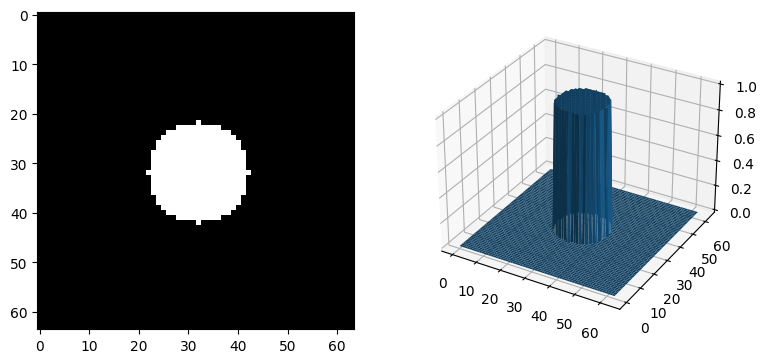

In [14]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_lp_ideal, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img_lp_ideal.shape[0], 0:img_lp_ideal.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_lp_ideal ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Filtro passa-baixa Butterworth

$$
H(u, v) = {\frac{1}{1 + \left( {D(u, v) \over D_0} \right) ^{2n}}}
$$

In [15]:
# Parametros
# ----------------------------------------
# Frequencia de corte
d0 = 10
# Ordem do filtro
n = 2
# ----------------------------------------

# Coordenadas do pixel central
center = np.array(img_ret.shape) // 2
print(center)

# Distancias de todos os pixels a partir do centro da imagem.
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Transformada da distância Euclidiana
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_lp_but = 1. / (1 + (img_dist / d0)**(2 * n))

[32 32]


#### Plota a função de transferência

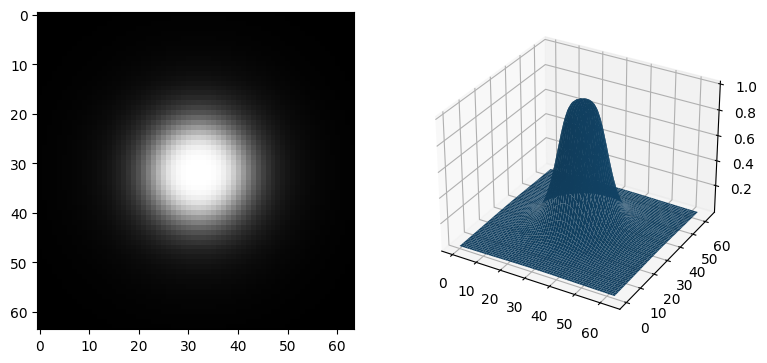

In [16]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_lp_but, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img_lp_but.shape[0], 0:img_lp_but.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Filtro passa-baixa Gaussiano

$$
H(u, v) = e^{\frac{-D^2(u, v)}{2 D^2_0}}
$$

In [17]:
# Parametros
# ----------------------------------------
# Frequencia de corte
d0 = 10
# ----------------------------------------

# Coordenadas do pixel central
center = np.array(img_ret.shape) // 2
print(center)

# Distancias de todos os pixels a partir do centro da imagem.
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Transformada da distância Euclidiana
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_lp_gaus = np.exp(-img_dist**2 / (2 * d0**2))

[32 32]


#### Plota a função de transferência

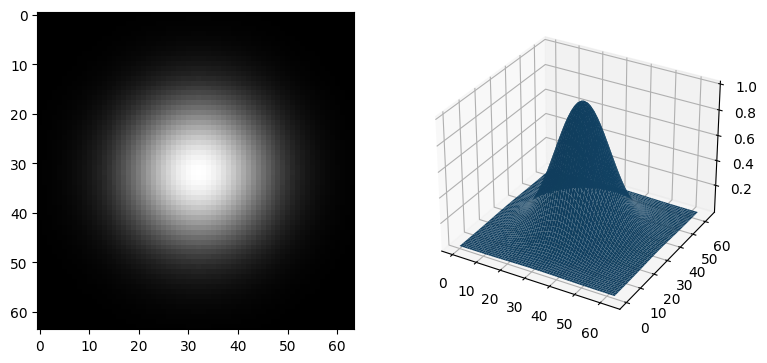

In [18]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_lp_gaus, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img_lp_gaus.shape[0], 0:img_lp_gaus.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_lp_gaus ,rstride=1, cstride=1, linewidth=0)

plt.show()

## Aplicando a filtragem passa-baixa com as funções de transferência

### Filtro passa-baixa ideal

In [19]:
# Computa a  Transformada de Fourier
img_ret_fft = np.fft.fft2(img_ret)
# Desloca os componentes com frequencia zero para o centro da imagem
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Aplica o filtro passa-baixa (por multiplicação)...
img_ret_lp_ideal = img_ret_fft_s * img_lp_ideal

# Desloca os componentes com frequencia zero de volta para os cantos da imagem
img_ret_lp_ideal_ifft_s = np.fft.ifftshift(img_ret_lp_ideal)
# Transformada inversa de Fourier
img_ret_lp_ideal_ifft = np.fft.ifft2(img_ret_lp_ideal_ifft_s)

#### Plota o processo de filtragem

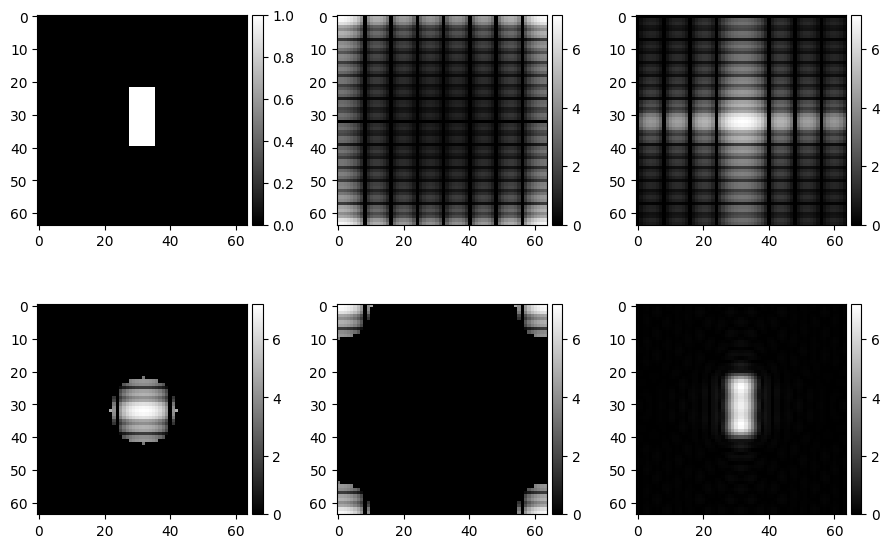

In [20]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_lp_ideal)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_lp_ideal_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(np.abs(img_ret_lp_ideal_ifft), cmap='gray')
## ax[i,4].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
plt.show()

### Filtro passa-baixa Butterworth

In [21]:
# Computa a  Transformada de Fourier
img_ret_fft = np.fft.fft2(img_ret)
# Desloca os componentes com frequencia zero para o centro da imagem
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Aplica o filtro passa-baixa Butterworth (por multiplicação)...
img_ret_lp_but = img_ret_fft_s * img_lp_but

# Desloca os componentes com frequencia zero de volta para os cantos da imagem
img_ret_lp_but_ifft_s = np.fft.ifftshift(img_ret_lp_but)
# Transformada inversa de Fourier
img_ret_lp_but_ifft = np.fft.ifft2(img_ret_lp_but_ifft_s)

#### Plotando as imagens

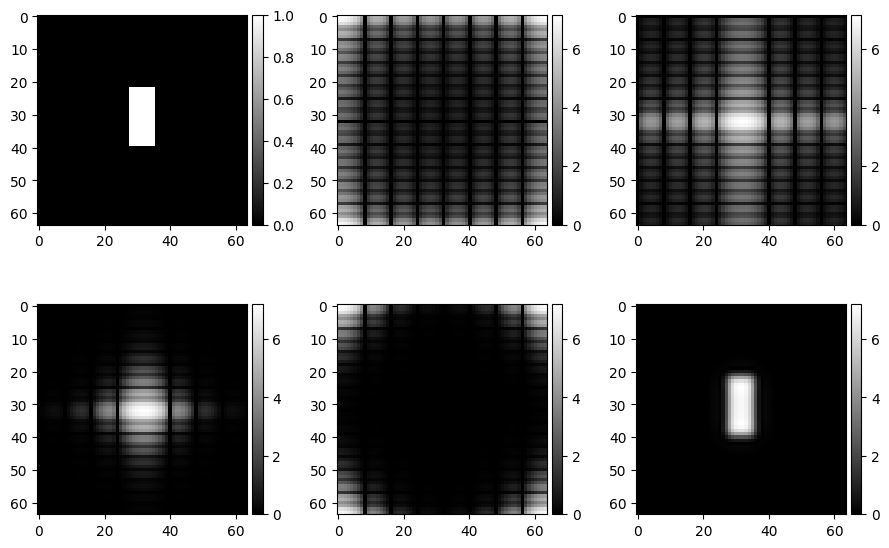

In [22]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_lp_but)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_lp_but_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(np.abs(img_ret_lp_but_ifft), cmap='gray')
## ax[i,4].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
plt.show()

### Filtro passa-baixa Gaussiano

In [23]:
# Computa a  Transformada de Fourier
img_ret_fft = np.fft.fft2(img_ret)
# Desloca os componentes com frequencia zero para o centro da imagem
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Aplica o filtro passa-baixa Gaussiano (por multiplicação)...
img_ret_lp_gaus = img_ret_fft_s * img_lp_gaus

# Desloca os componentes com frequencia zero de volta para os cantos da imagem
img_ret_lp_gaus_ifft_s = np.fft.ifftshift(img_ret_lp_gaus)
# Transformada inversa de Fourier
img_ret_lp_gaus_ifft = np.fft.ifft2(img_ret_lp_gaus_ifft_s)

#### Plotando as imagens

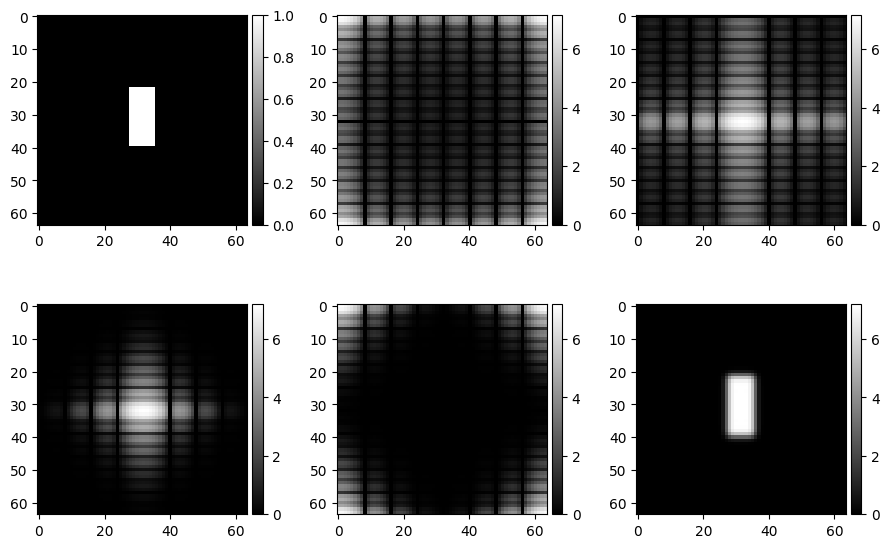

In [24]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_lp_gaus)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_lp_gaus_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(np.log2(1 + np.abs(img_ret_lp_gaus_ifft)), cmap='gray')
## ax[i,4].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

## Filtros passa-alta
----

### Filtro passa-alta ideal

<br />
<font size="5">
$H(u, v) = 
\begin{cases}
&1, \:\: \text{ if } D(u, v) > D_0 \\
&0, \:\: \text{ if } D(u, v) \leq D_0
\end{cases}
$
</font>

In [25]:
# Parametros
# ----------------------------------------
# Frequencia de corte
d0 = 10
# ----------------------------------------

# Coordenadas do pixel central
center = np.array(img_ret.shape) // 2
print(center)

# Distancias de todos os pixels a partir do centro da imagem.
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Transformada da distância Euclidiana
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_hp_ideal = img_dist > d0

[32 32]


#### Plotando as função de transição

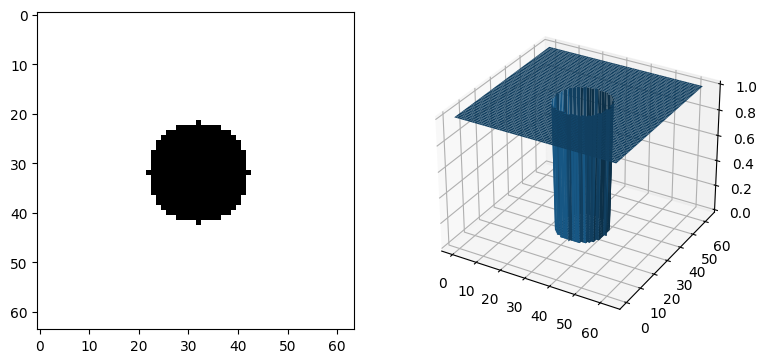

In [26]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_hp_ideal, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img_hp_ideal.shape[0], 0:img_hp_ideal.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_hp_ideal ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Filtro passa-alta Butterworth

<br />
<font size="5">
$H(u, v) = {\frac{1}{1 + \left( {D_0 \over D(u, v)} \right) ^{2n}}}$
</font>

In [27]:
# Parametros
# ----------------------------------------
# Frequencia de corte
d0 = 10
# Ordem do filtro
n = 2
# ----------------------------------------

# Coordenadas do pixel central
center = np.array(img_ret.shape) // 2
print(center)

# Distancias de todos os pixels a partir do centro da imagem.
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Transformada da distância Euclidiana
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_hp_but = 1. / (1 + (d0 / img_dist)**(2 * n))

[32 32]


C:\Users\joaof\AppData\Local\Temp\ipykernel_6748\1886622649.py:19: RuntimeWarning: divide by zero encountered in divide
  img_hp_but = 1. / (1 + (d0 / img_dist)**(2 * n))


#### Plotando a função de transição

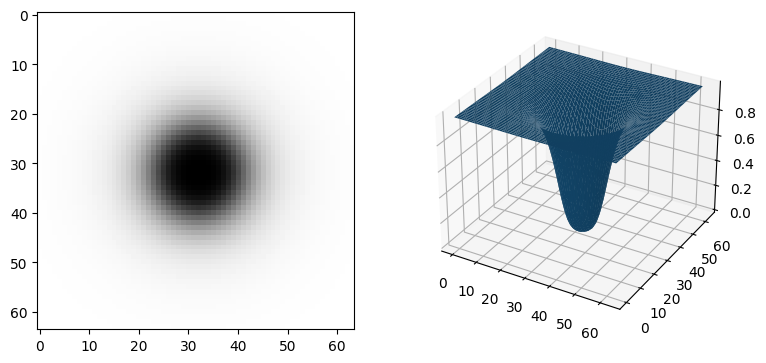

In [28]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_hp_but, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img_hp_but.shape[0], 0:img_hp_but.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_hp_but ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Filtro passa-alta Gaussiano


<br />
<font size="6">
$H(u, v) = 1 - e^{\frac{-D^2(u, v)}{2 D^2_0}}$
</font>

In [29]:
# Parametros
# ----------------------------------------
# Frequencia de corte
d0 = 10
# ----------------------------------------

# Coordenadas do pixel central
center = np.array(img_ret.shape) // 2
print(center)

# Distancias de todos os pixels a partir do centro da imagem.
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Transformada da distância Euclidiana
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_hp_gaus = 1 - np.exp(-img_dist**2 / (2 * d0**2))

[32 32]


#### Plotando a função de transição

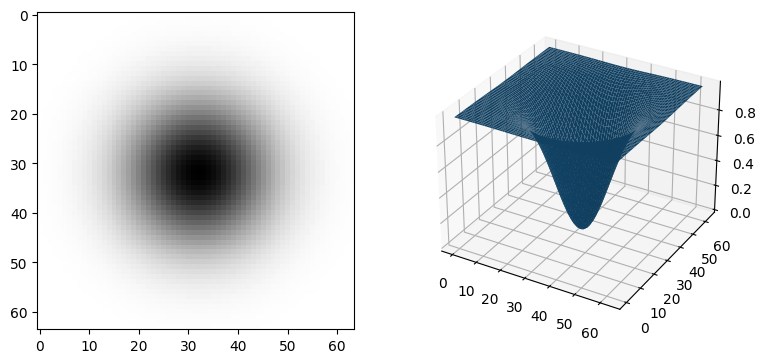

In [30]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_hp_gaus, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img_hp_gaus.shape[0], 0:img_hp_gaus.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_hp_gaus ,rstride=1, cstride=1, linewidth=0)

plt.show()

## Aplicando a filtragem passa-alta com as funções de transferência

### Filtro passa-alta ideal

In [31]:
# Computa a  Transformada de Fourier
img_ret_fft = np.fft.fft2(img_ret)
# Desloca os componentes com frequencia zero para o centro da imagem
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Aplica o filtro passa-lat (por multiplicação)...
img_ret_hp_ideal = img_ret_fft_s * img_hp_ideal

# Desloca os componentes com frequencia zero de volta para os cantos da imagem
img_ret_hp_ideal_ifft_s = np.fft.ifftshift(img_ret_hp_ideal)
# Transformada inversa de Fourier
img_ret_hp_ideal_ifft = np.fft.ifft2(img_ret_hp_ideal_ifft_s)

img_ret_hp_ideal_ifft = np.abs(img_ret_hp_ideal_ifft)

#### Plotando as imagens

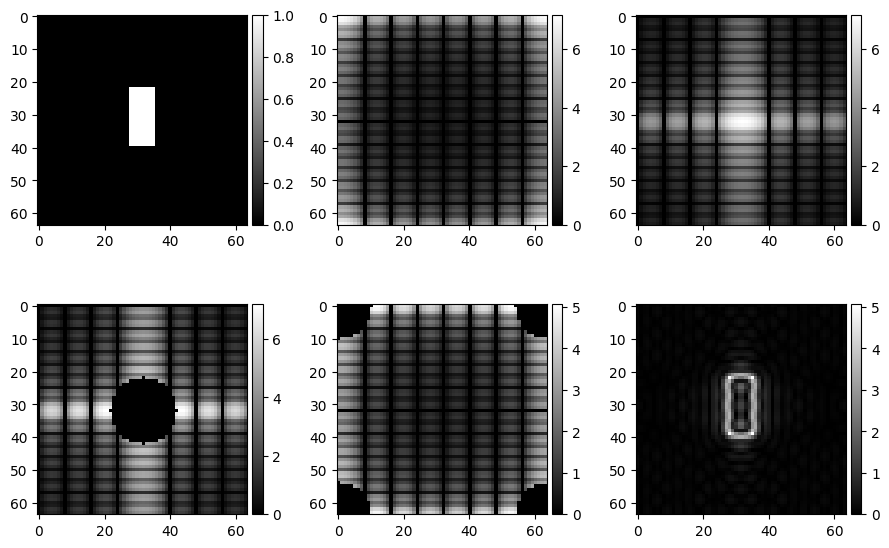

In [32]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_hp_ideal)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_hp_ideal_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(img_ret_hp_ideal_ifft, cmap='gray')
## ax[i,4].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

### Filtro passa-alta Butterworth

In [33]:
# Computa a  Transformada de Fourier
img_ret_fft = np.fft.fft2(img_ret)
# Desloca os componentes com frequencia zero para o centro da imagem
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Aplica o filtro passa-alta (por multiplicação)...
img_ret_hp_but = img_ret_fft_s * img_hp_but

# Desloca os componentes com frequencia zero de volta para os cantos da imagem
img_ret_hp_but_ifft_s = np.fft.ifftshift(img_ret_hp_but)
# Transformada inversa de Fourier
img_ret_hp_but_ifft = np.fft.ifft2(img_ret_hp_but_ifft_s)

img_ret_hp_but_ifft = np.abs(img_ret_hp_but_ifft)

#### Plotando as imagens

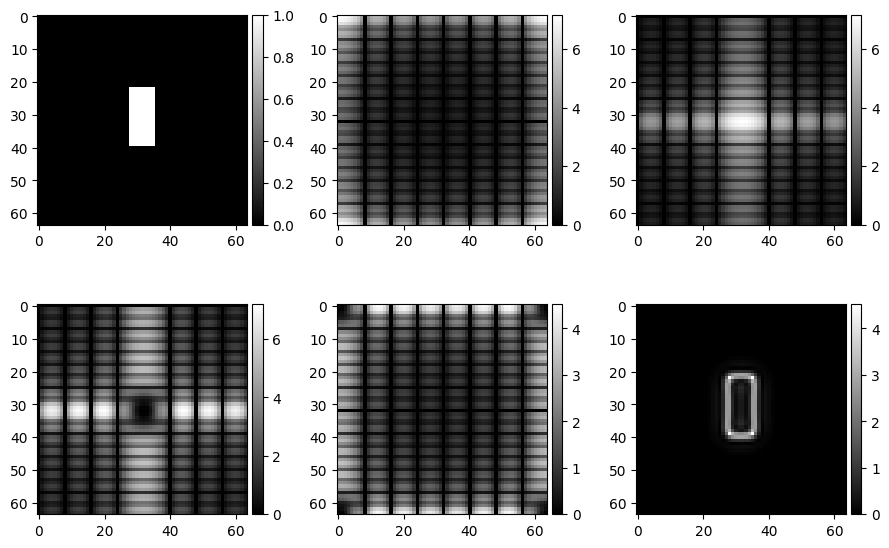

In [34]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_hp_but)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_hp_but_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(img_ret_hp_but_ifft, cmap='gray')
## ax[i,4].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

### Filtro passa-alta Gaussiano

In [35]:
# Computa a  Transformada de Fourier
img_ret_fft = np.fft.fft2(img_ret)
# Desloca os componentes com frequencia zero para o centro da imagem
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Aplica o filtro passa-lat (por multiplicação)...
img_ret_hp_gaus = img_ret_fft_s * img_hp_gaus

# Desloca os componentes com frequencia zero de volta para os cantos da imagem
img_ret_hp_gaus_ifft_s = np.fft.ifftshift(img_ret_hp_gaus)
# Transformada inversa de Fourier
img_ret_hp_gaus_ifft = np.fft.ifft2(img_ret_hp_gaus_ifft_s)

img_ret_hp_gaus_ifft = np.abs(img_ret_hp_gaus_ifft)

#### Plotando as imagens

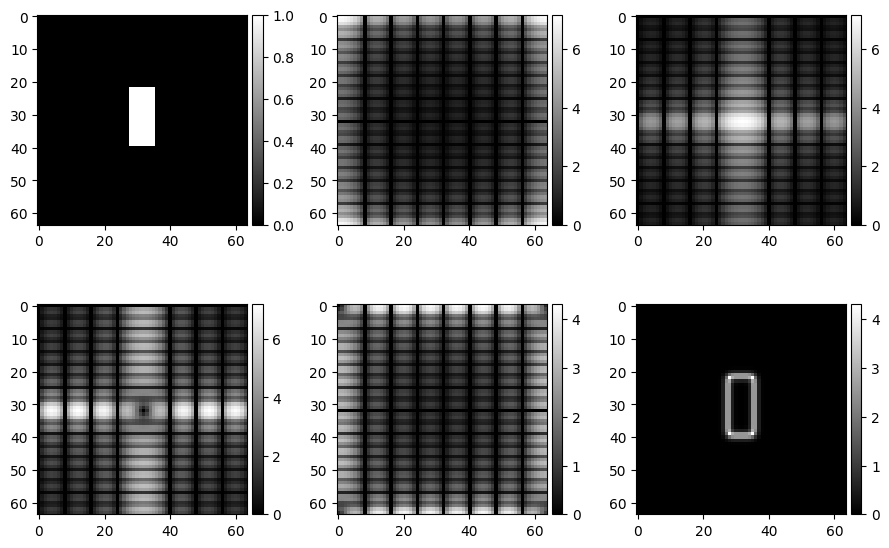

In [36]:
fig, ax  = plt.subplots(2, 3, figsize=(9,6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_hp_gaus)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_hp_gaus_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(img_ret_hp_gaus_ifft, cmap='gray')
## ax[i,4].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

## Example with a real image
---

Now, we will repeate the previouly operations using a real image.

(512, 512) float32 0.033336863 0.99691176


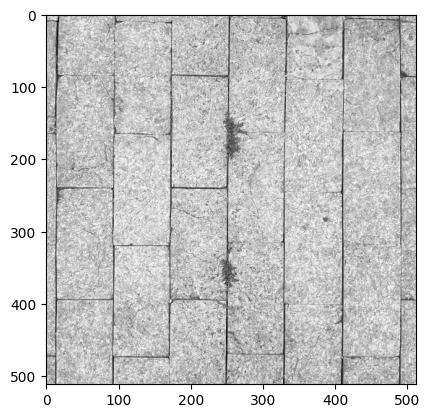

In [37]:
img_ret = plt.imread('./images/sidewalk_01_square_512x512.png')

# Remove o canal transparente
img_ret = img_ret[:,:,:-1]

# Converte para niveis de cinza
img_ret = color.rgb2gray(img_ret)

# Informações sobre as imagens
print(img_ret.shape, img_ret.dtype, img_ret.min(), img_ret.max())

# Plota a imagem
plt.figure()
plt.imshow(img_ret, cmap='gray')
plt.show()

### Transformando a imagem

* Iremos gerar duas versões transformadas da imagem original, uma transladada e outra rotacionada.

In [38]:
# Translation
# -----------
tform = transform.EuclideanTransform(
            translation=(16, -16))

img_ret_t = transform.warp(img_ret, tform.inverse)

# Rotation
# --------
shift_y, shift_x = np.array(img_ret.shape) // 2

tf_r = transform.SimilarityTransform(rotation=np.deg2rad(60))
tf_t1 = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
tf_t2 = transform.SimilarityTransform(translation=[shift_x, shift_y])

img_ret_r = transform.warp(img_ret, (tf_t1 + (tf_r + tf_t2)).inverse, order=3)

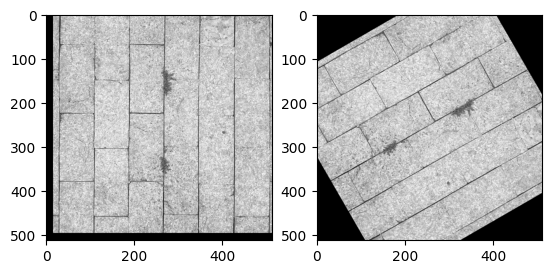

In [39]:
# Plota a imagem
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_ret_t, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_ret_r, cmap='gray')
plt.show()

### Aplicando a Transformada de Fourier adiante e a Transformada de Fourier inversa

In [40]:
img_list = [img_ret, img_ret_t, img_ret_r]

img_fft_list = []
img_fft_s_list = []
img_ifft_s_list = []
img_ifft_list = []

for img in img_list:
    img_fft = np.fft.fft2(img)
    img_fft_s = np.fft.fftshift(img_fft)
    img_ifft_s = np.fft.ifftshift(img_fft_s)
    img_ifft = np.fft.ifft2(img_ifft_s)
    
    img_fft_list.append(img_fft)
    img_fft_s_list.append(img_fft_s)
    img_ifft_s_list.append(img_ifft_s)
    img_ifft_list.append(img_ifft)

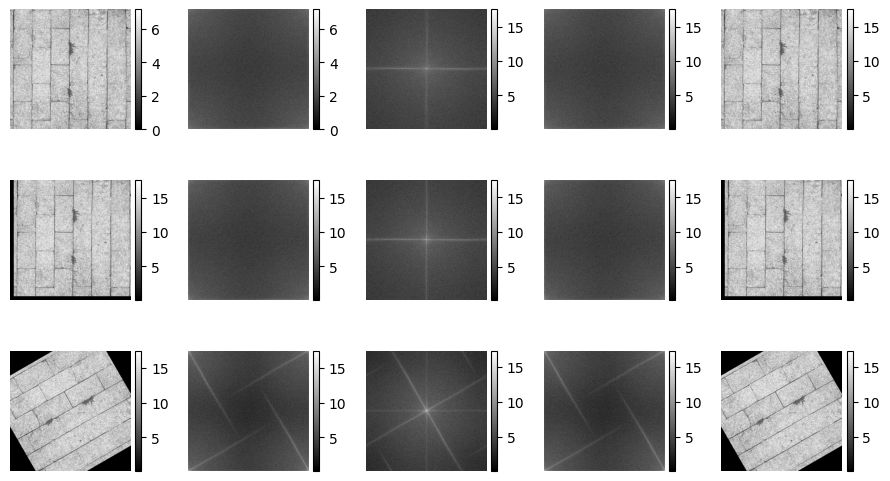

In [41]:
fig, ax  = plt.subplots(3, 5, figsize=(9,6))
for i, (img, img_fft, img_fft_s, img_ifft_s, img_ifft) in enumerate(zip(img_list, img_fft_list, img_fft_s_list, img_ifft_s_list, img_ifft_list)):

    img_1 = ax[i, 0].imshow(img, cmap='gray')
    ax[i,0].axis('off')
    # Barra de cores
    divider = make_axes_locatable(ax[i,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_3, cax=cax)
    
    img_2 = ax[i,1].imshow(np.log2(1 + np.abs(img_fft)), cmap='gray')
    ax[i,1].axis('off')
    # Barra de cores
    divider = make_axes_locatable(ax[i,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_3, cax=cax)
    
    img_3 = ax[i,2].imshow(np.log2(1 + np.abs(img_fft_s)), cmap='gray')
    ax[i,2].axis('off')
    # Barra de cores
    divider = make_axes_locatable(ax[i,2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_3, cax=cax)
    
    img_4 = ax[i,3].imshow(np.log2(1 + np.abs(img_ifft_s)), cmap='gray')
    ax[i,3].axis('off')
    # Barra de cores
    divider = make_axes_locatable(ax[i,3])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_3, cax=cax)
    
    img_5 = ax[i,4].imshow(np.abs(img_ifft), cmap='gray')
    ax[i,4].axis('off')
    # Barra de cores
    divider = make_axes_locatable(ax[i,4])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img_3, cax=cax)
    
    fig.tight_layout()
    
plt.show()

In [ ]:
# Parametros
# ----------------------------------------
# Frequencia de corte
d0 = 10
# ----------------------------------------

# Coordenadas do pixel central
center = np.array(img_ret.shape) // 2
print(center)

# Distancias de todos os pixels a partir do centro da imagem.
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Transformada da distância Euclidiana
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_lp_ideal = img_dist <= d0

In [ ]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_lp_ideal, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img_lp_ideal.shape[0], 0:img_lp_ideal.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_lp_ideal ,rstride=1, cstride=1, linewidth=0)

plt.show()

In [ ]:
# Parametros
# ----------------------------------------
# Frequencia de corte
d0 = 10
# Ordem do filtro
n = 2
# ----------------------------------------

# Coordenadas do pixel central
center = np.array(img_ret.shape) // 2
print(center)

# Distancias de todos os pixels a partir do centro da imagem.
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Transformada da distância Euclidiana
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_lp_but = 1. / (1 + (img_dist / d0)**(2 * n))

In [ ]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_lp_but, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# Create arrays dor the x and y coordinates.
xx, yy = np.mgrid[0:img_lp_but.shape[0], 0:img_lp_but.shape[1]]
ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Filtro passa-baixa Gaussiano

$$
H(u, v) = e^{\frac{-D^2(u, v)}{2 D^2_0}}
$$

In [ ]:
# Parametros
# ----------------------------------------
# Frequencia de corte
d0 = 10
# ----------------------------------------

# Coordenadas do pixel central
center = np.array(img_ret.shape) // 2
print(center)

# Distancias de todos os pixels a partir do centro da imagem.
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Transformada da distância Euclidiana
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_lp_gaus = np.exp(-img_dist**2 / (2 * d0**2))

In [ ]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_lp_gaus, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img_lp_gaus.shape[0], 0:img_lp_gaus.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_lp_gaus ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Aplicando a filtragem passa-baixa com as funções de transferência

#### Filtro passa-baixa ideal

In [ ]:
# Computa a  Transformada de Fourier
img_ret_fft = np.fft.fft2(img_ret)
# Desloca os componentes com frequencia zero para o centro da imagem
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Aplica o filtro passa-baixa (por multiplicação)...
img_ret_lp_ideal = img_ret_fft_s * img_lp_ideal

# Desloca os componentes com frequencia zero de volta para os cantos da imagem
img_ret_lp_ideal_ifft_s = np.fft.ifftshift(img_ret_lp_ideal)
# Transformada inversa de Fourier
img_ret_lp_ideal_ifft = np.fft.ifft2(img_ret_lp_ideal_ifft_s)

##### Plota o processo de filtragem

In [ ]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_lp_ideal)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_lp_ideal_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(np.abs(img_ret_lp_ideal_ifft), cmap='gray')
## ax[i,4].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
plt.show()

### Filtro passa-baixa Butterworth

In [ ]:
# Computa a  Transformada de Fourier
img_ret_fft = np.fft.fft2(img_ret)
# Desloca os componentes com frequencia zero para o centro da imagem
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Aplica o filtro passa-baixa Butterworth (por multiplicação)...
img_ret_lp_but = img_ret_fft_s * img_lp_but

# Desloca os componentes com frequencia zero de volta para os cantos da imagem
img_ret_lp_but_ifft_s = np.fft.ifftshift(img_ret_lp_but)
# Transformada inversa de Fourier
img_ret_lp_but_ifft = np.fft.ifft2(img_ret_lp_but_ifft_s)

In [ ]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_lp_but)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_lp_but_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(np.abs(img_ret_lp_but_ifft), cmap='gray')
## ax[i,4].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
plt.show()

### Filtro passa-baixa Gaussiano

In [ ]:
# Computa a  Transformada de Fourier
img_ret_fft = np.fft.fft2(img_ret)
# Desloca os componentes com frequencia zero para o centro da imagem
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Aplica o filtro passa-baixa Gaussiano (por multiplicação)...
img_ret_lp_gaus = img_ret_fft_s * img_lp_gaus

# Desloca os componentes com frequencia zero de volta para os cantos da imagem
img_ret_lp_gaus_ifft_s = np.fft.ifftshift(img_ret_lp_gaus)
# Transformada inversa de Fourier
img_ret_lp_gaus_ifft = np.fft.ifft2(img_ret_lp_gaus_ifft_s)

In [ ]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_lp_gaus)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_lp_gaus_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(np.log2(1 + np.abs(img_ret_lp_gaus_ifft)), cmap='gray')
## ax[i,4].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

## Filtros passa-alta
----

### Filtro passa-alta ideal

$$
H(u, v) = 
\begin{cases}
&1, \:\: \text{ if } D(u, v) > D_0 \\
&0, \:\: \text{ if } D(u, v) \leq D_0
\end{cases}
$$

In [ ]:
# Parametros
# ----------------------------------------
# Frequencia de corte
d0 = 10
# ----------------------------------------

# Coordenadas do pixel central
center = np.array(img_ret.shape) // 2
print(center)

# Distancias de todos os pixels a partir do centro da imagem.
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Transformada da distância Euclidiana
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_hp_ideal = img_dist > d0

#### Plotting the transition function

In [ ]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_hp_ideal, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img_hp_ideal.shape[0], 0:img_hp_ideal.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_hp_ideal ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Filtro passa-alta Butterworth

$$
H(u, v) = {\frac{1}{1 + \left( {D_0 \over D(u, v)} \right) ^{2n}}}
$$

In [ ]:
# Parametros
# ----------------------------------------
# Frequencia de corte
d0 = 10
# Ordem do filtro
n = 2

# Coordenadas do pixel central
center = np.array(img_ret.shape) // 2
print(center)

# Distancias de todos os pixels a partir do centro da imagem.
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Transformada da distância Euclidiana
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_hp_but = 1. / (1 + (d0 / img_dist)**(2 * n))

#### Plotting the transition function

In [ ]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_hp_but, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img_hp_but.shape[0], 0:img_hp_but.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_hp_but ,rstride=1, cstride=1, linewidth=0)

plt.show()

### Filtro passa-alta Gaussiano

$$
H(u, v) = 1 - e^{\frac{-D^2(u, v)}{2 D^2_0}}
$$

In [ ]:
# Parametros
# ----------------------------------------
# Frequencia de corte
d0 = 10
# ----------------------------------------

# Coordenadas do pixel central
center = np.array(img_ret.shape) // 2
print(center)

# Distancias de todos os pixels a partir do centro da imagem.
img_dist = np.zeros(img_ret.shape, dtype=bool)
img_dist[center[0], center[1]] = 1
# Transformada da distância Euclidiana
img_dist = ndimage.distance_transform_edt(~img_dist.astype(bool))

img_hp_gaus = 1 - np.exp(-img_dist**2 / (2 * d0**2))

#### Plotting the transition function

In [1]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_hp_gaus, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img_hp_gaus.shape[0], 0:img_hp_gaus.shape[1]]
## ax2.plot_surface(xx, yy, img_lp_but ,rstride=1, cstride=1, cmap='gray', linewidth=0)
ax2.plot_surface(xx, yy, img_hp_gaus ,rstride=1, cstride=1, linewidth=0)

plt.show()

NameError: name 'plt' is not defined

### Aplicando a filtragem passa-alta com as funções de transferência

#### Filtro passa-alta ideal

In [ ]:
# Computa a  Transformada de Fourier
img_ret_fft = np.fft.fft2(img_ret)
# Desloca os componentes com frequencia zero para o centro da imagem
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Aplica o filtro passa-alta (por multiplicação)...
img_ret_hp_ideal = img_ret_fft_s * img_hp_ideal

# Desloca os componentes com frequencia zero de volta para os cantos da imagem
img_ret_hp_ideal_ifft_s = np.fft.ifftshift(img_ret_hp_ideal)
# Transformada inversa de Fourier
img_ret_hp_ideal_ifft = np.fft.ifft2(img_ret_hp_ideal_ifft_s)

img_ret_hp_ideal_ifft = np.abs(img_ret_hp_ideal_ifft)

##### Plotting the images

In [ ]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_hp_ideal)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_hp_ideal_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(img_ret_hp_ideal_ifft, cmap='gray')
## ax[i,4].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

#### Filtro passa-alta Butterworth

In [ ]:
# Computa a  Transformada de Fourier
img_ret_fft = np.fft.fft2(img_ret)
# Desloca os componentes com frequencia zero para o centro da imagem
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Aplica o filtro passa-alta (por multiplicação)...
img_ret_hp_but = img_ret_fft_s * img_hp_but

# Desloca os componentes com frequencia zero de volta para os cantos da imagem
img_ret_hp_but_ifft_s = np.fft.ifftshift(img_ret_hp_but)
# Transformada inversa de Fourier
img_ret_hp_but_ifft = np.fft.ifft2(img_ret_hp_but_ifft_s)

img_ret_hp_but_ifft = np.abs(img_ret_hp_but_ifft)

##### Plotando as imagens

In [ ]:
fig, ax  = plt.subplots(2, 3, figsize=(9, 6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_hp_but)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_hp_but_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(img_ret_hp_but_ifft, cmap='gray')
## ax[i,4].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

#### Filtro passa-alta Gaussiano

In [ ]:
# Computa a  Transformada de Fourier
img_ret_fft = np.fft.fft2(img_ret)
# Desloca os componentes com frequencia zero para o centro da imagem
img_ret_fft_s = np.fft.fftshift(img_ret_fft)

# Aplica o filtro passa-lat (por multiplicação)...
img_ret_hp_gaus = img_ret_fft_s * img_hp_gaus

# Desloca os componentes com frequencia zero de volta para os cantos da imagem
img_ret_hp_gaus_ifft_s = np.fft.ifftshift(img_ret_hp_gaus)
# Transformada inversa de Fourier
img_ret_hp_gaus_ifft = np.fft.ifft2(img_ret_hp_gaus_ifft_s)

img_ret_hp_gaus_ifft = np.abs(img_ret_hp_gaus_ifft)

##### Plotting the images

In [ ]:
fig, ax  = plt.subplots(2, 3, figsize=(9,6))

img_1 = ax[0,0].imshow(img_ret, cmap='gray')
## ax[i,0].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_1, cax=cax)

img_2 = ax[0,1].imshow(np.log2(1 + np.abs(img_ret_fft)), cmap='gray')
## ax[i,1].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_2, cax=cax)

img_3 = ax[0,2].imshow(np.log2(1 + np.abs(img_ret_fft_s)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_4 = ax[1,0].imshow(np.log2(1 + np.abs(img_ret_hp_gaus)), cmap='gray')
## ax[i,2].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_3, cax=cax)

img_5 = ax[1,1].imshow(np.log2(1 + np.abs(img_ret_hp_gaus_ifft_s)), cmap='gray')
## ax[i,3].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_4, cax=cax)

img_6 = ax[1,2].imshow(img_ret_hp_gaus_ifft, cmap='gray')
## ax[i,4].axis('off')
# Barra de cores
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_5, cax=cax)

fig.tight_layout()
    
plt.show()

## Bibliografia
----

* GONZALEZ, R.C.; WOODS, R.E.; Processamento Digital de Imagens. 3ª edição. Editora Pearson, 2009.
* MARQUES FILHO, O.; VIEIRA NETO, H. Processamento digital de imagens. Brasport, 1999.
    * Disponível para download no site do autor (Exclusivo para uso pessoal)
    * http://dainf.ct.utfpr.edu.br/~hvieir/pub.html  
* J. E. R. Queiroz, H. M. Gomes. Introdução ao Processamento Digital de Imagens. RITA. v. 13, 2006.
    * http://www.dsc.ufcg.edu.br/~hmg/disciplinas/graduacao/vc-2016.2/Rita-Tutorial-PDI.pdf  
* Gaël Varoquaux Emmanuelle Gouillart; Olav Vahtras; Pierre de Buyl (editores). Scipy Lecture Notes. Release 2020.1
    * Disponível em: http://scipy-lectures.org/
* scikit-image. Documentação.
    * https://scikit-image.org/docs/dev/index.html
* NumPy. Documentação.
    * https://numpy.org/doc/stable/
* Plotting and manipulating FFTs for filtering
    * https://scipy-lectures.org/intro/scipy/auto_examples/plot_fftpack.html
* Understanding the FFT Algorithm 
    * https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/
* Digital Image Processing using Fourier Transform in Python
    * https://medium.com/@hicraigchen/digital-image-processing-using-fourier-transform-in-python-bcb49424fd82